In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
import os
import random
import progressbar
import pickle
import sys
from PIL import Image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications, regularizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, LSTM, Dropout, MaxPooling1D, MaxPooling2D, TimeDistributed, Conv1D, Conv2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.metrics as metrics
from tensorflow.math import confusion_matrix
#!pip install -U efficientnet
import tensorflow.keras.applications.efficientnet as efn
#import efficientnet.keras as efn
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN, SMOTETomek
import seaborn as sb
import time
import math
import statistics
from google.colab import drive
drive.mount('/content/gdrive')

data_per_csv = 512
size = (32,32,2) #(data_per_csv,2,2)
classify = {
    'h':0,
    'd':1
}

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc', curve='ROC'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


HRV images data path

In [ ]:
def DataPath(c, num):
  if c=='d':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Images/Diabetes/' + str(num) + '_'
  elif c=='h':
    return 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Images/Healthy/' + str(num) + '_'
  else:
    raise ValueError('Parameter must be h or d')

Total number of pseudo-images in All

In [ ]:
def total():
  total_files = 0
  for files in os.listdir('gdrive/My Drive/Summer Research/HRV/Outlier Free/Wavelet Transformed Data/All/'):
    total_files += 1
  return total_files

Import HRV data

In [ ]:
def importAllData(c):
  widgets = [' [',
        progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
        '] ',
          progressbar.Bar('#'),' (',
          progressbar.ETA(), ') ',
          ]
  all_total = total()
  bar = progressbar.ProgressBar(max_value=all_total, widgets=widgets).start()
  master_list = list()
  count = 0
  if c == 'wt':
    data_path = 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Wavelet Transformed Data/All/'

    for files in os.listdir(data_path):
      count += 1
      bar.update(count)
      sublist = list()
      h_or_d = classify[files[0]]
      image = Normalize(np.loadtxt(data_path+files, delimiter=','))
      sublist.append(image)
      sublist.append(h_or_d)
      master_list.append(sublist)
  elif c == 'wt denoised':
    data_path = 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Wavelet Transform Denoised Data/All/'
    
    for files in os.listdir(data_path):
      count += 1
      bar.update(count)
      sublist = list()
      h_or_d = classify[files[0]]
      image = Normalize(np.loadtxt(data_path+files, delimiter=','))
      sublist.append(image)
      sublist.append(h_or_d)
      master_list.append(sublist)
  elif c == 'normal':
    data_path = 'gdrive/My Drive/Summer Research/HRV/Outlier Free/Images/All/'

    for files in os.listdir(data_path):
      count += 1
      bar.update(count)
      sublist = list()
      h_or_d = classify[files[0]]

      arr = np.array(Image.open(data_path+files))
      arr_scaled = np.zeros(arr.shape)
      scaler = MinMaxScaler(feature_range = (0, 1))
      for i in range(4):
        arr_scaled[:,:,i] = scaler.fit_transform(arr[:,:,i])
      sublist.append(arr_scaled)
      sublist.append(h_or_d)
      master_list.append(sublist)
  return master_list

Normalization (returns scaled array)

In [ ]:
def Normalize(arr):
  arr_scaled = np.zeros(size)
  scaler = MinMaxScaler(feature_range = (0, 1))
  arr_scaled = scaler.fit_transform(arr).reshape(size)
#  arr_scaled[:,:,0] = scaler.fit_transform(arr[:,0:2])
#  arr_scaled[:,:,1] = scaler.fit_transform(arr[:,2:4])
  return arr_scaled

Create model

In [ ]:
def CNN_Model(m, model_weights=None, num_of_layers=None):
  model = Sequential()
  if m == 'resnet50':
    model.add(applications.resnet50.ResNet50(
        include_top=False, weights=model_weights, input_tensor=None,
        input_shape=size, pooling=max))
    model.add(Dense(1, activation='sigmoid'))
    for layer in model.layers:
        layer.trainable = False
  elif m == 'efficientnet':
    model.add(efn.EfficientNetB0(input_shape = size,
                                 include_top = True,
                                 weights = model_weights))
    #model.add(Dense(2, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    for layer in model.layers:
      layer.trainable = False
  elif m == 'efn+lstm':
    dim1, dim2, dim3 = size
    model.add(efn.EfficientNetB0(input_shape = size,
                                 include_top = False, weights = model_weights,
                                 classes = 2, pooling = 'avg'))
    #model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=50, return_sequences=True, input_shape=((dim1*dim2//8), 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    for layer in model.layers:
      layer.trainable = True
  elif m == 'cnn':
    dim1, dim2, dim3 = size
    for i in range(num_of_layers):
      tpow = 2**i
      model.add(Conv2D(filters=dim1*tpow, kernel_size=3,
                                      activation='relu', padding='same'))
      model.add(MaxPooling2D(pool_size=(2)))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    for layer in model.layers:
      layer.trainable = True
  elif m == 'cnn+lstm':
    dim1, dim2, dim3 = size
    for i in range(num_of_layers):
      tpow = 2**i
      model.add(TimeDistributed(Conv1D(filters=dim1*tpow, kernel_size=3,
                                      activation='relu', padding='same')))
      model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=70, return_sequences=True, input_shape=((dim1*dim2//2**(num_of_layers-1)), 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    for layer in model.layers:
      layer.trainable = True
  return model

Evaluate model (takes fit model as parameter, returns test loss and test accuracy)

In [ ]:
def evaluateModel(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  return model.evaluate(test_images, test_labels, verbose=2)

Save/load HRV data

In [ ]:
def saveHRVData(c):
  hrv_and_labels = importAllData(c)
  if c == 'wt':
    with open('gdrive/My Drive/Summer Research/Variables/wt_pseudoimage_hrv_and_labels.pkl', 'wb') as file:
      #save data to a file
      pickle.dump(hrv_and_labels, file)
  elif c == 'wt denoised':
    with open('gdrive/My Drive/Summer Research/Variables/wt_denoised_pseudoimage_hrv_and_labels.pkl', 'wb') as file:
      #save data to a file
      pickle.dump(hrv_and_labels, file)
  elif c == 'normal':
    with open('gdrive/My Drive/Summer Research/Variables/normal_hrv_and_labels.pkl', 'wb') as file:
      #save data to a file
      pickle.dump(hrv_and_labels, file)


In [ ]:
def loadHRVData(c):
  hrv_and_labels = list()
  if c == 'wt':
    with open('gdrive/My Drive/Summer Research/Variables/wt_pseudoimage_hrv_and_labels.pkl', 'rb') as file:
      #load data from file
      hrv_and_labels = pickle.load(file)
  elif c == 'wt denoised':
    with open('gdrive/My Drive/Summer Research/Variables/wt_denoised_pseudoimage_hrv_and_labels.pkl', 'rb') as file:
      #load data from file
      hrv_and_labels = pickle.load(file)
  elif c == 'normal':
    size = (163, 223, 4)
    with open('gdrive/My Drive/Summer Research/Variables/normal_hrv_and_labels.pkl', 'rb') as file:
      #load data from file
      hrv_and_labels = pickle.load(file)
  elif c == 'array':
    with open('gdrive/My Drive/Summer Research/Variables/array_hrv_and_labels.pkl', 'rb') as file:
      #load data from file
      hrv_and_labels = pickle.load(file)
  elif c == 'wt a1d1d2d3 coords':
    with open('gdrive/My Drive/Summer Research/Variables/wt_a1d1d2d3_coords_hrv_and_labels.pkl', 'rb') as file:
      #save data to a file
      hrv_and_labels = pickle.load(file)
  elif c == 'wt a1d1d2d3 denoised coords':
    with open('gdrive/My Drive/Summer Research/Variables/wt_a1d1d2d3_denoised_coords_hrv_and_labels.pkl', 'rb') as file:
      #save data to a file
      hrv_and_labels = pickle.load(file)
  return hrv_and_labels

In [ ]:
def saveModelWeights():
  with open('gdrive/My Drive/Summer Research/Variables/model_weights.pkl', 'wb') as file:
    #save data to a file
    pickle.dump(model.get_weights(), file)

In [ ]:
def loadModelWeights():
  with open('gdrive/My Drive/Summer Research/Variables/model_weights.pkl', 'rb') as file:
    #save data to a file
    model_weights = pickle.load(file)

In [ ]:
#saveHRVData('normal')

Oversampling and undersampling

In [ ]:
def resampling(args):
  if args == 'SMOTEENN':
    resampler = SMOTEENN(n_jobs=-1)
  elif args == 'SMOTETomek':
    resampler = SMOTETomek()
  
  return resampler

In [ ]:
hrv_and_labels = loadHRVData('wt denoised')
random.shuffle(hrv_and_labels)
tvt_size = {'train':int(0.6*len(hrv_and_labels)), 'val':int(0.1*len(hrv_and_labels)), 'test':int(0.3*len(hrv_and_labels))}

hrv = np.array([item[0] for item in hrv_and_labels])
labels = np.array([item[1] for item in hrv_and_labels])

train_hrv = hrv[:tvt_size['train']]#.reshape(-1,32,32,2,1)
val_hrv = hrv[tvt_size['train']:(tvt_size['train']+tvt_size['val'])]#.reshape(-1,32,32,2,1)
test_hrv = hrv[(tvt_size['train']+tvt_size['val']):(tvt_size['train']+tvt_size['val']+tvt_size['test'])]#.reshape(-1,32,32,2,1)

train_labels = labels[:tvt_size['train']]
val_labels = labels[tvt_size['train']:(tvt_size['train']+tvt_size['val'])]
test_labels = labels[(tvt_size['train']+tvt_size['val']):(tvt_size['train']+tvt_size['val']+tvt_size['test'])]

#Create model
model = CNN_Model('cnn', model_weights=None, num_of_layers=5)
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=METRICS)

history = model.fit(train_hrv,
          train_labels,
          epochs=100,
          validation_data=(val_hrv, val_labels),
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5,
                                   mode='min', restore_best_weights=True)])

Epoch 1/100
71/71 [==============================] - 27s 347ms/step - loss: 0.5555 - tp: 4.0000 - fp: 28.0000 - tn: 891.1409 - fn: 228.7324 - accuracy: 0.7402 - precision: 0.1250 - recall: 0.0435 - auc: 0.4382 - prc: 0.1841 - val_loss: 0.4797 - val_tp: 4.0000 - val_fp: 28.0000 - val_tn: 1962.7500 - val_fn: 475.6667 - val_accuracy: 0.7961 - val_precision: 0.1250 - val_recall: 0.0084 - val_auc: 0.4742 - val_prc: 0.1836
Epoch 2/100
71/71 [==============================] - 24s 340ms/step - loss: 0.5097 - tp: 4.0000 - fp: 28.0000 - tn: 3032.0564 - fn: 727.8169 - accuracy: 0.8003 - precision: 0.1250 - recall: 0.0056 - auc: 0.4766 - prc: 0.1834 - val_loss: 0.4867 - val_tp: 4.0000 - val_fp: 28.0000 - val_tn: 4094.7500 - val_fn: 983.6667 - val_accuracy: 0.8020 - val_precision: 0.1250 - val_recall: 0.0041 - val_auc: 0.4811 - val_prc: 0.1847
Epoch 3/100
71/71 [==============================] - 24s 342ms/step - loss: 0.5044 - tp: 4.0000 - fp: 28.0000 - tn: 5160.0703 - fn: 1239.8029 - accuracy: 0.8

36/36 [==============================] - 1s 34ms/step - loss: 0.5467 - tp: 4.0000 - fp: 28.0000 - tn: 20484.0547 - fn: 4966.3613 - accuracy: 0.8040 - precision: 0.1250 - recall: 8.0495e-04 - auc: 0.5072 - prc: 0.1959


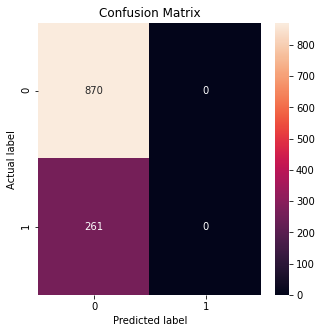

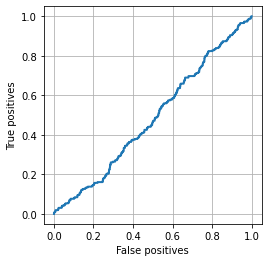

In [ ]:
results = model.evaluate(test_hrv, test_labels, verbose=1, batch_size=32)
test_predictions_baseline = model.predict(test_hrv, batch_size=32)
metrics(test_labels, test_predictions_baseline)

Metrics

In [ ]:
def metrics(labels, predictions, p=0.5):
  #Confusion matrix
  results = model.evaluate(test_hrv, test_labels, verbose=1, batch_size=32)
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sb.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion Matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()
  #ROC curve
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(fp, tp, label='ROC Curve', linewidth=2)
  plt.xlabel('False positives')
  plt.ylabel('True positives')
  plt.xlim([-0.05,1.05])
  plt.ylim([-0.05,1.05])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')